In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


**Problem definition**

The goal of this competition is to predict a customer’s purchase value based on their multi-session behavior across digital touchpoints. The dataset captures anonymized user interactions such as browser types, traffic sources, device details, and geographical indicators. By modeling these patterns, participants will estimate the purchase potential of each user, helping optimize marketing and engagement strategies.

**Importing all libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

**Reading data**

In [3]:
df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')

**Statistical analysis**

In [4]:
print("Shape of dataset:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing values (%):\n", (df.isnull().sum() / len(df)) * 100)
print("\nSummary Statistics:\n", df.describe())
print("\nUnique value count:\n ",df.nunique())
single = (df.nunique() == 1)
print(df.columns[single].tolist())


Shape of dataset: (116023, 52)

Data Types:
 trafficSource.isTrueDirect                       object
purchaseValue                                   float64
browser                                          object
device.screenResolution                          object
trafficSource.adContent                          object
trafficSource.keyword                            object
screenSize                                       object
geoCluster                                       object
trafficSource.adwordsClickInfo.slot              object
device.mobileDeviceBranding                      object
device.mobileInputSelector                       object
userId                                            int64
trafficSource.campaign                           object
device.mobileDeviceMarketingName                 object
geoNetwork.networkDomain                         object
gclIdPresent                                      int64
device.operatingSystemVersion                    object
ses

### Initial Data analysis 
- Dataset Shape: There are 52 columns and 116,023 rows in the training dataset.
- Target Variable: The regression target is purchaseValue. It contains 6,766 distinct values and no missing values.

- User and Session Identifiers: userId and sessionId are specific to each user and session; they are helpful for aggregation but dangerous for direct modeling.
- Missing Values: Over 50% of several columns, including trafficSource.adContent and trafficSource.adwords, are missing values.ClickInfo.slot, trafficSource.isTrueDirect, and trafficSource.keyword, and they might need to be removed or handled differently.
- Feature Types: Device.screenResolution, device.mobileDeviceModel, and device.browserSize are examples of categorical features that each have a single distinct value. These are likely to be dropped because they don't provide any information.
- GeoNetwork.city and trafficSource.referral are examples of high-cardinality categorical columns.It is advised to encrypt the path, location, country, and target
- Skew and Sparsity: The target distribution is highly skewed, as evidenced by the large number of users with purchaseValue = 0.
- Binary or near-constant fields, such as totals.bounces, new_visits, and totals.visits, are helpful as boolean indicators.
- Date & Time: To extract temporal features like day, month, weekday, or time of day, date and sessionStart can be changed.


**1.Histogram for sessionStart, date, totalHits, purchaseValue,pageViews**

**2.Barchart for os, browser,contient,medium,device type, userchanel, network medium**

**3.Boxplot to find the outliers for sessionStart, date, totalHits, purchaseValue,pageViews**

**4. Correlation heatmap**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


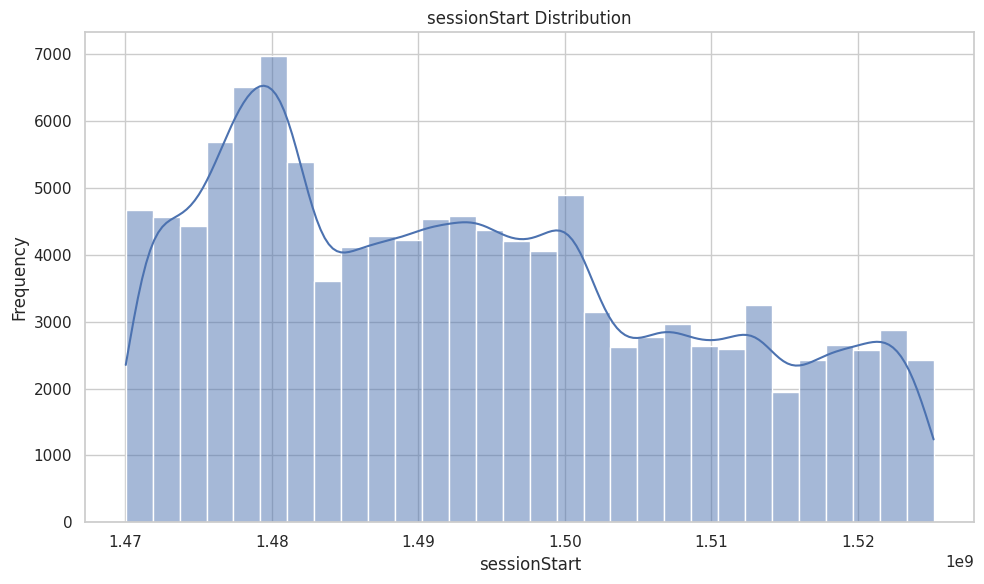

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


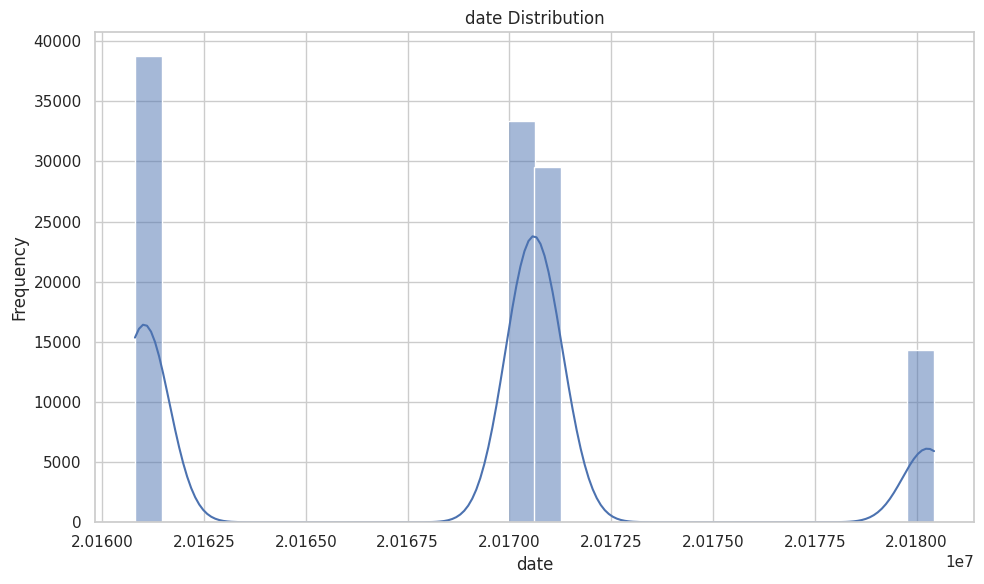

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


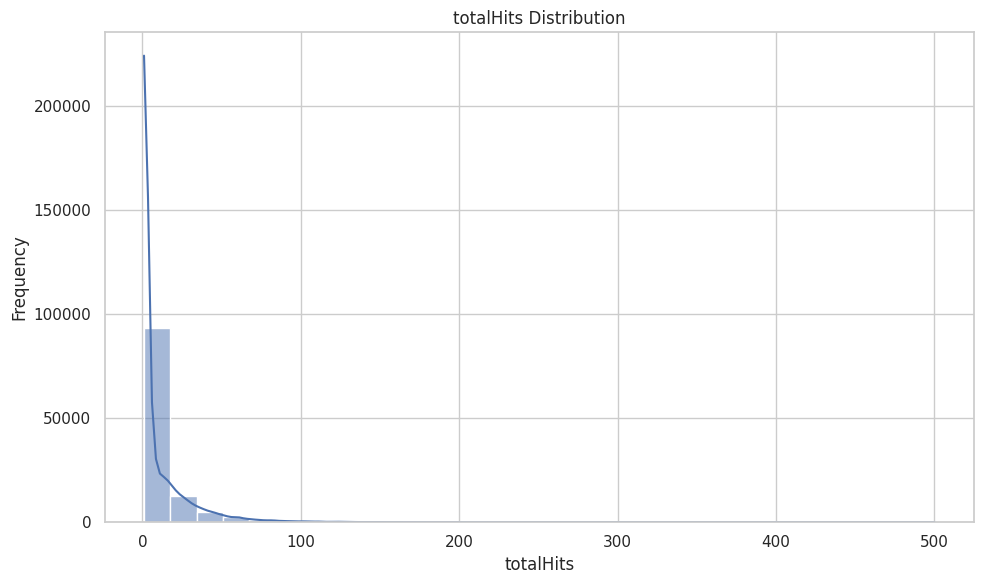

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


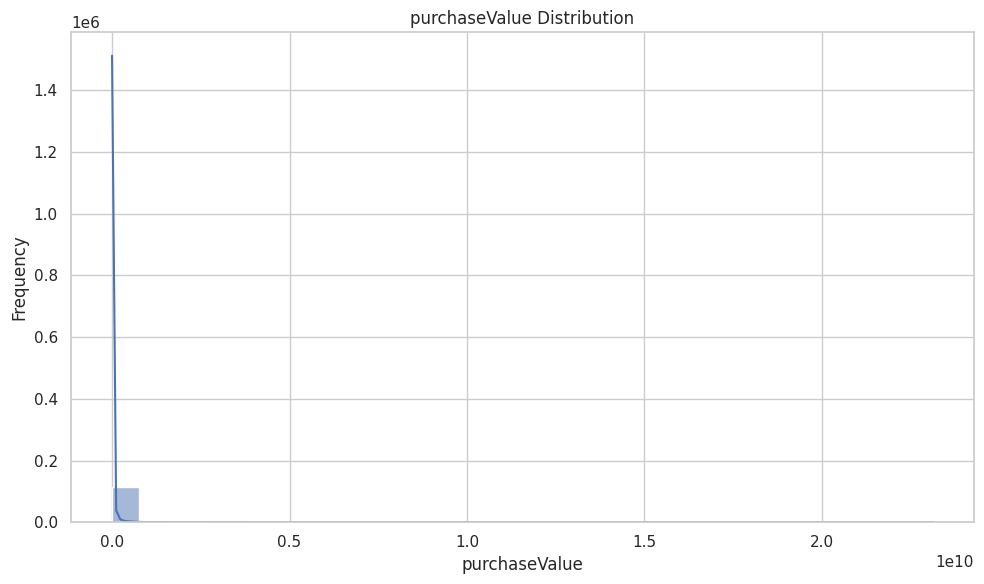

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


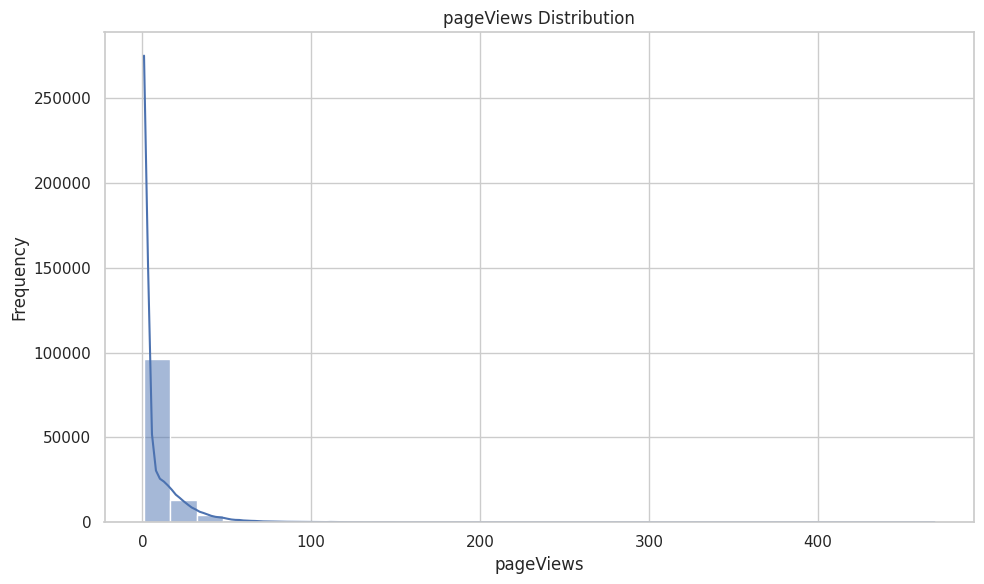

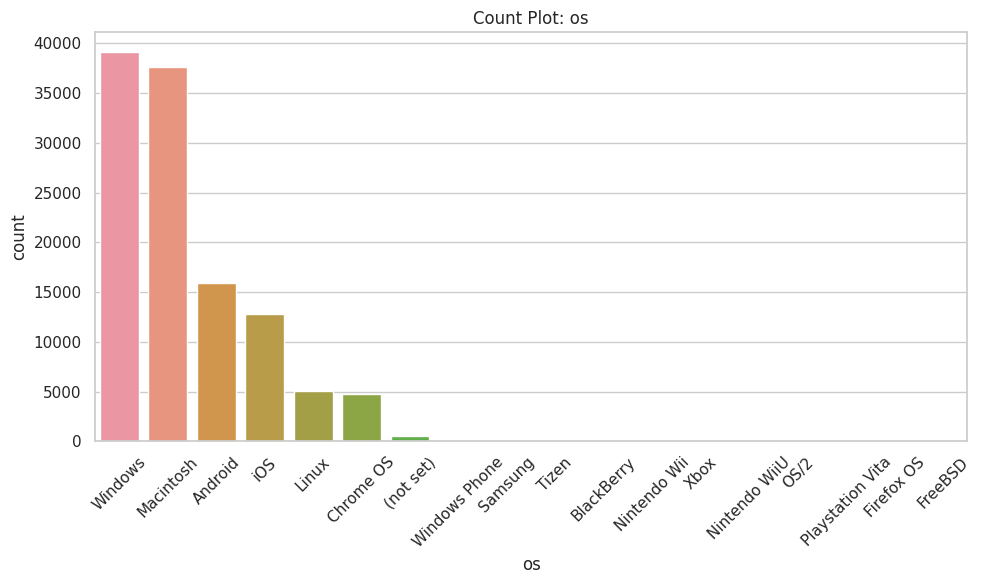

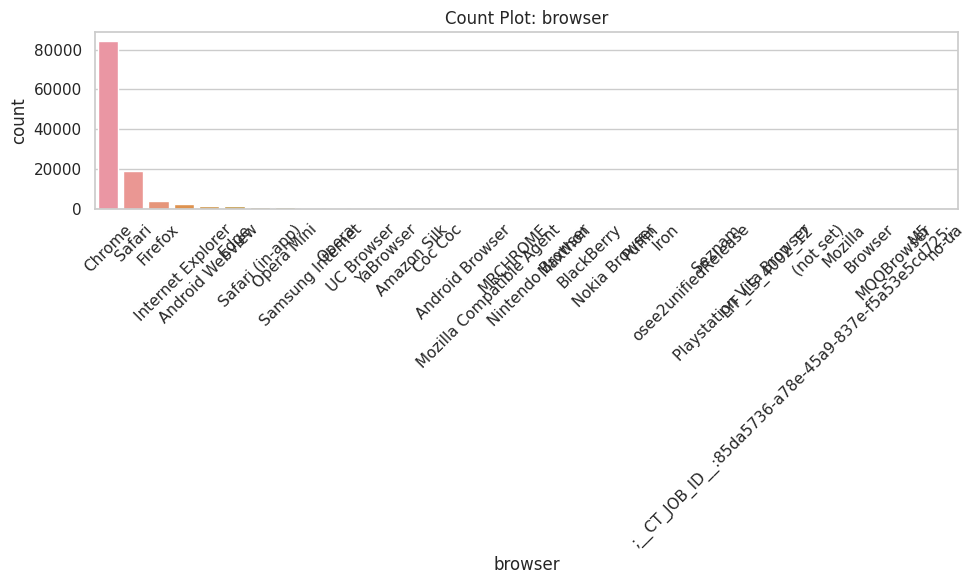

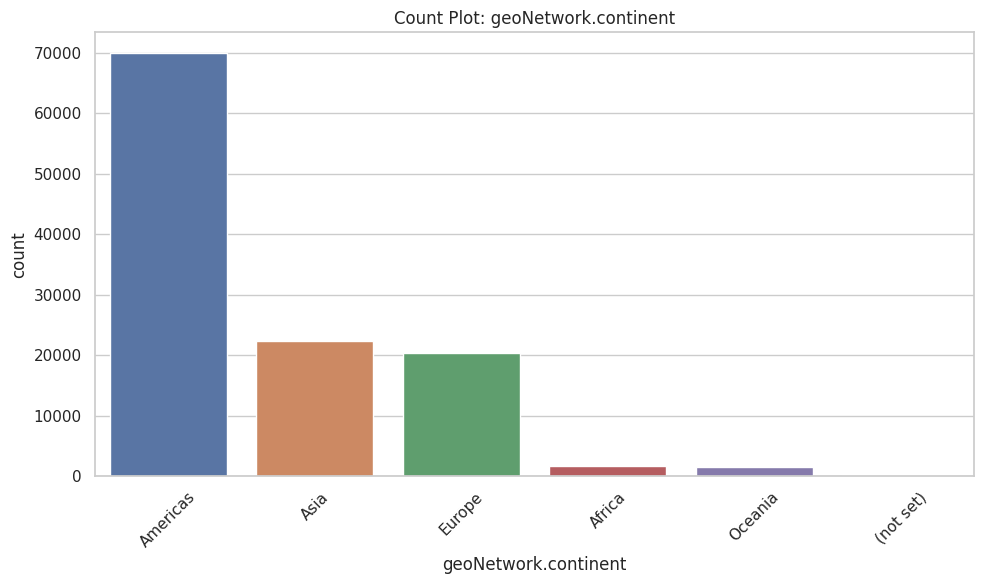

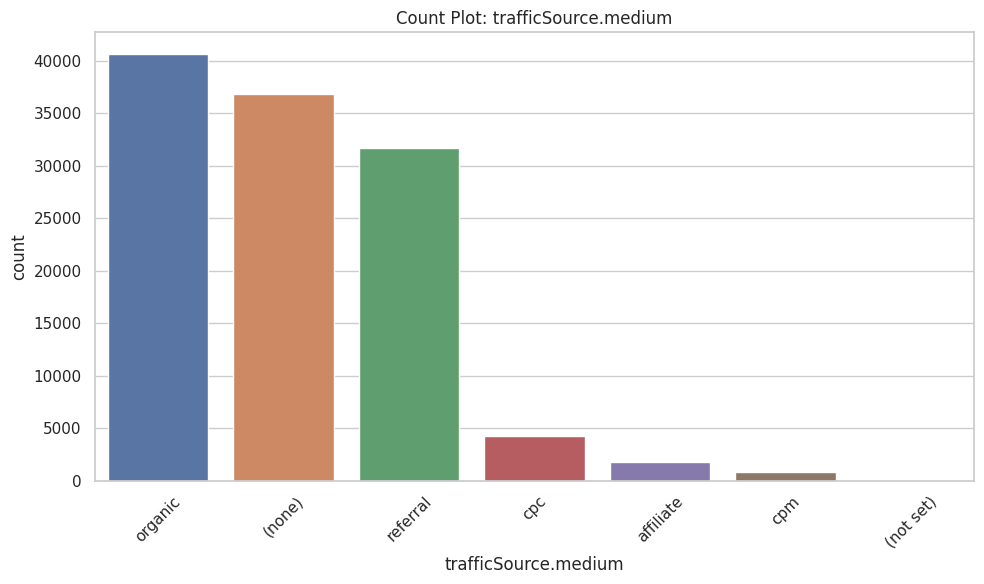

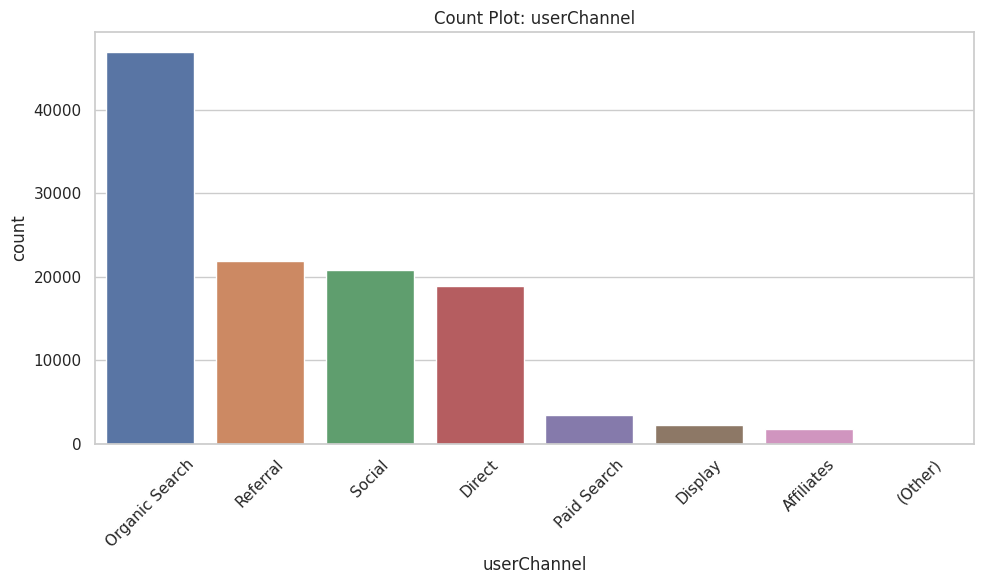

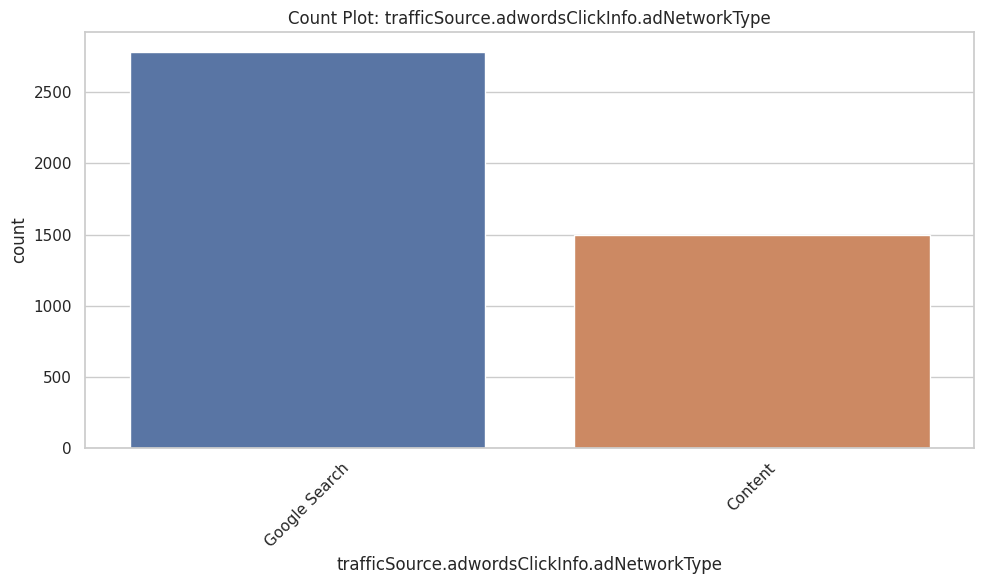

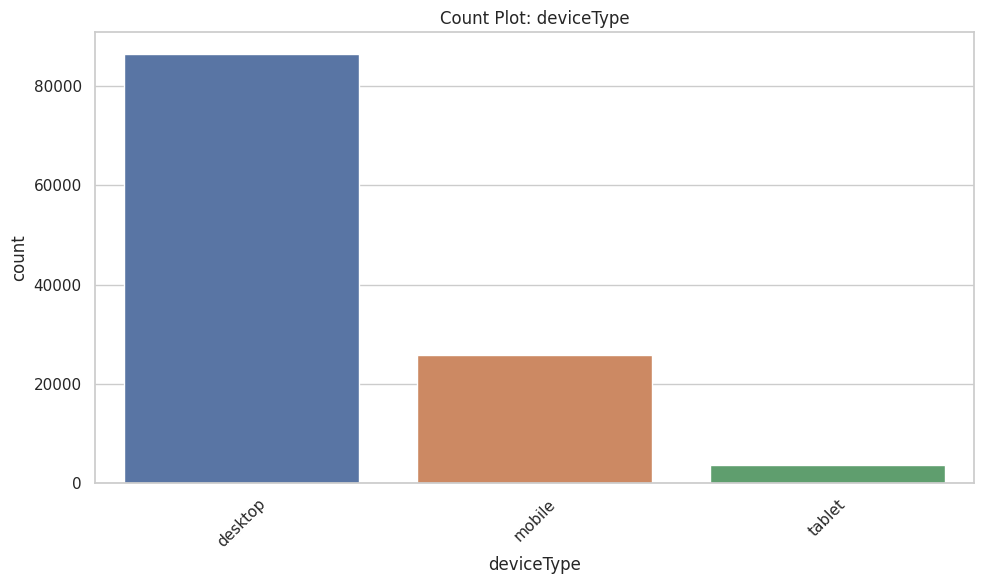

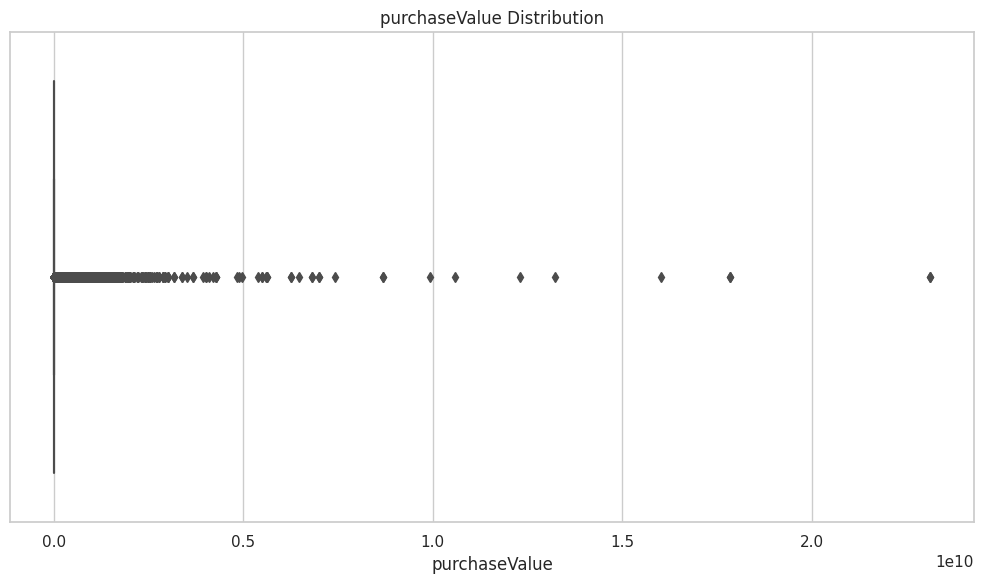

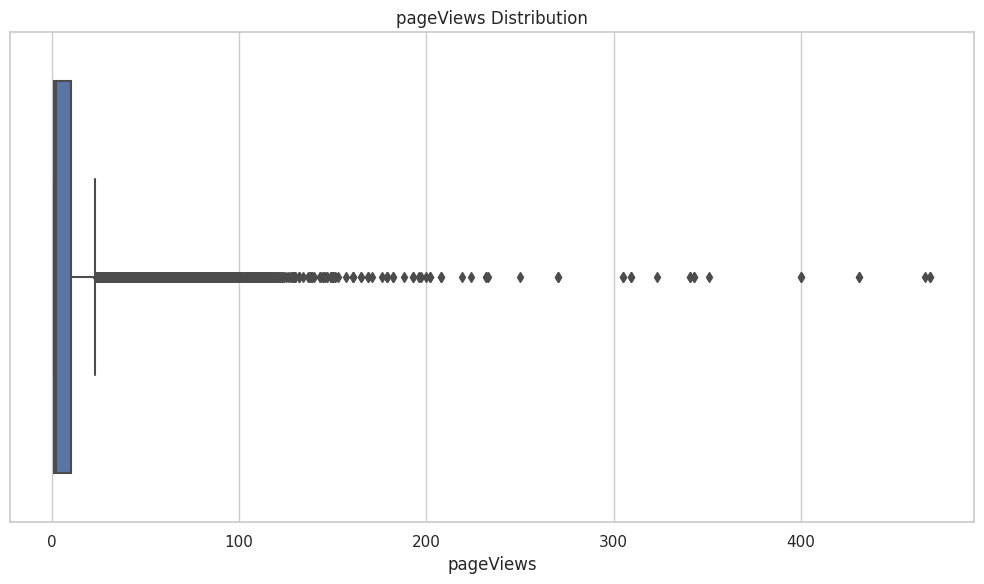

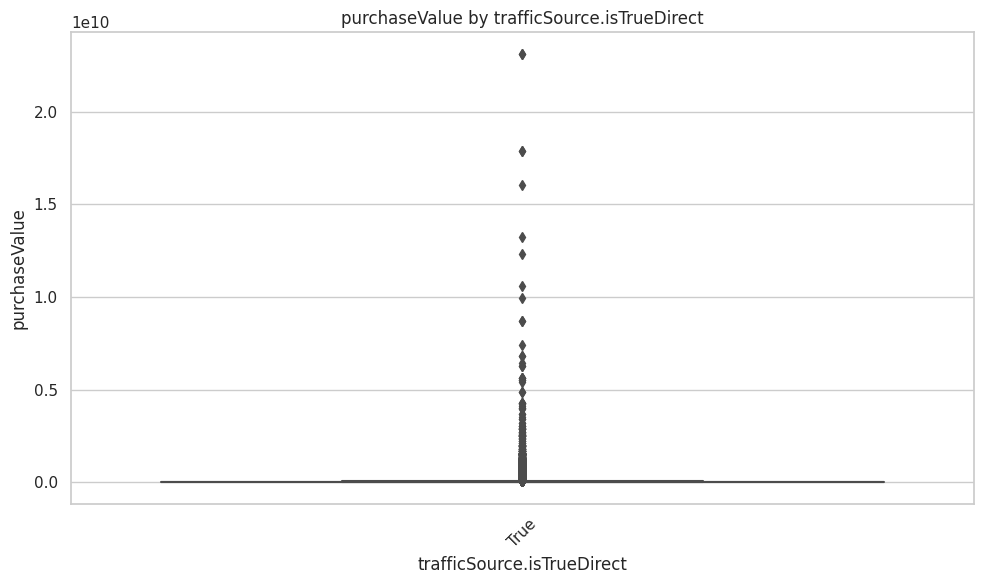

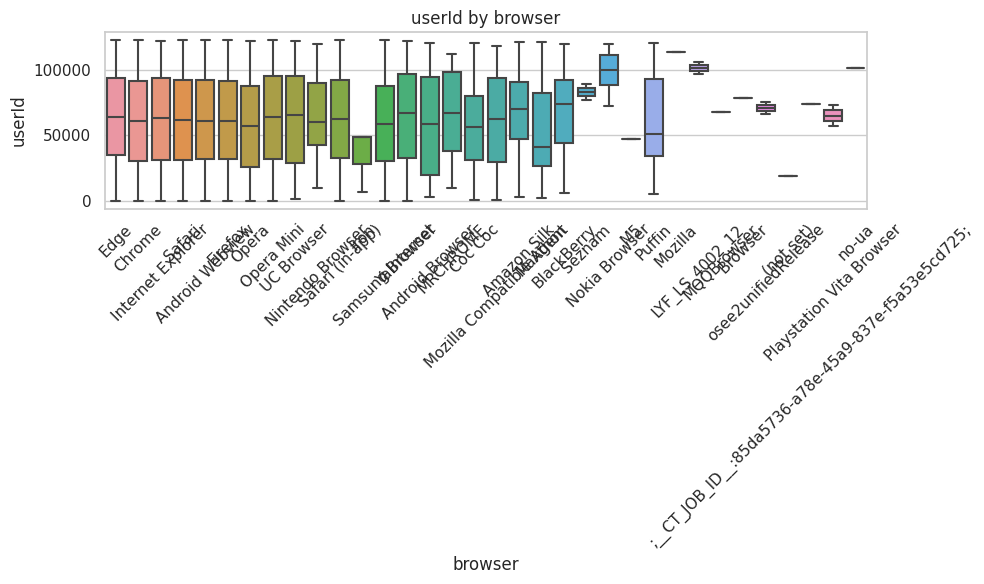

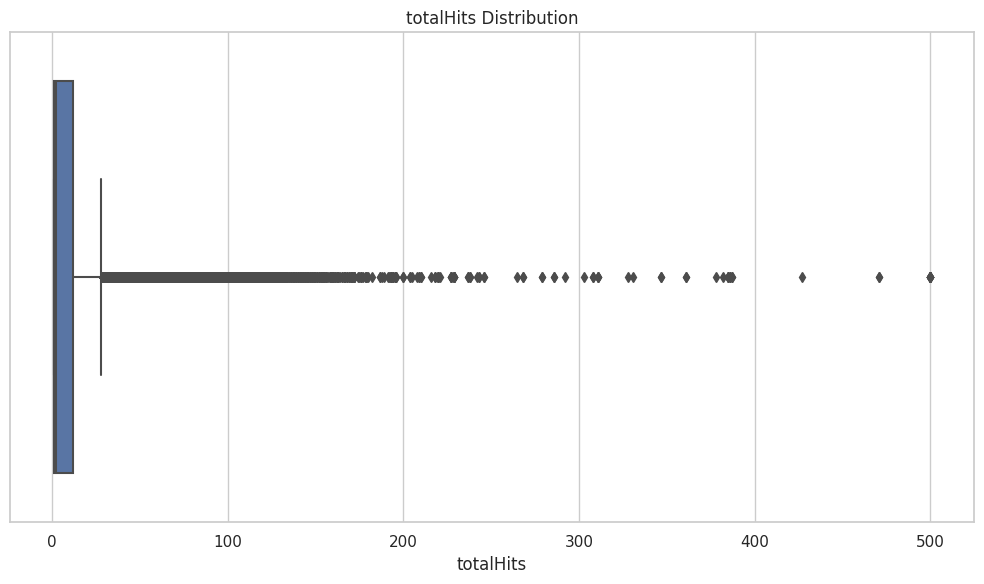

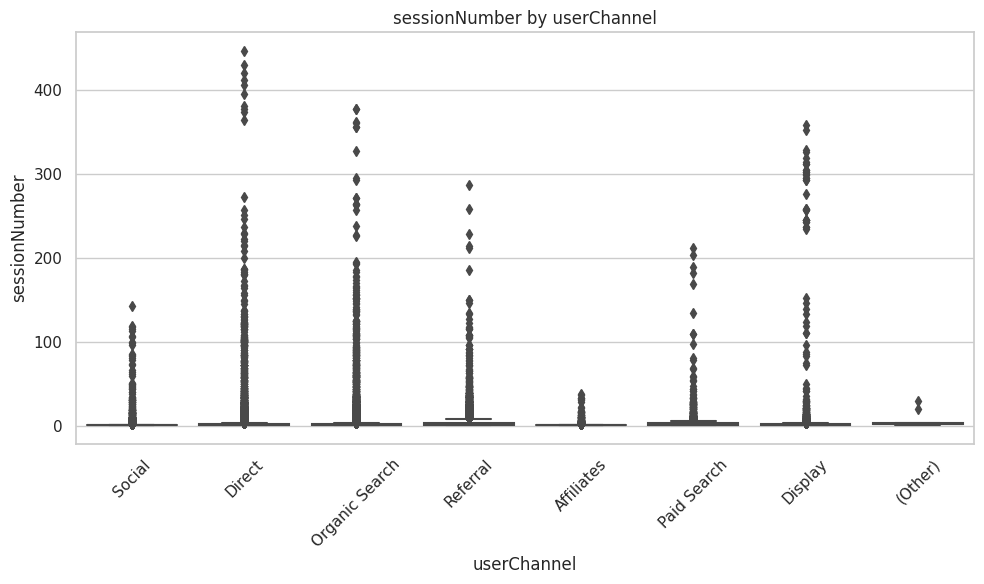

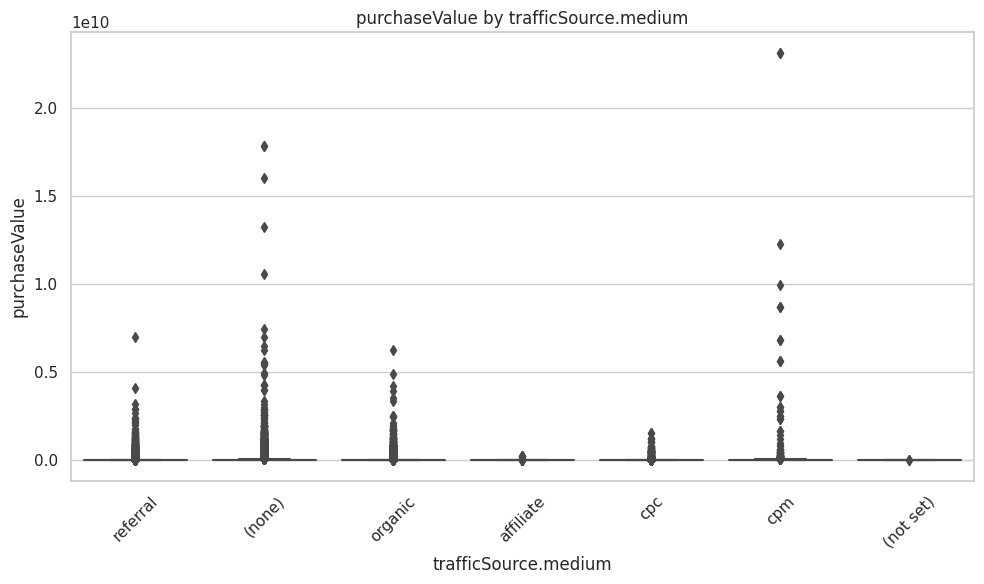

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


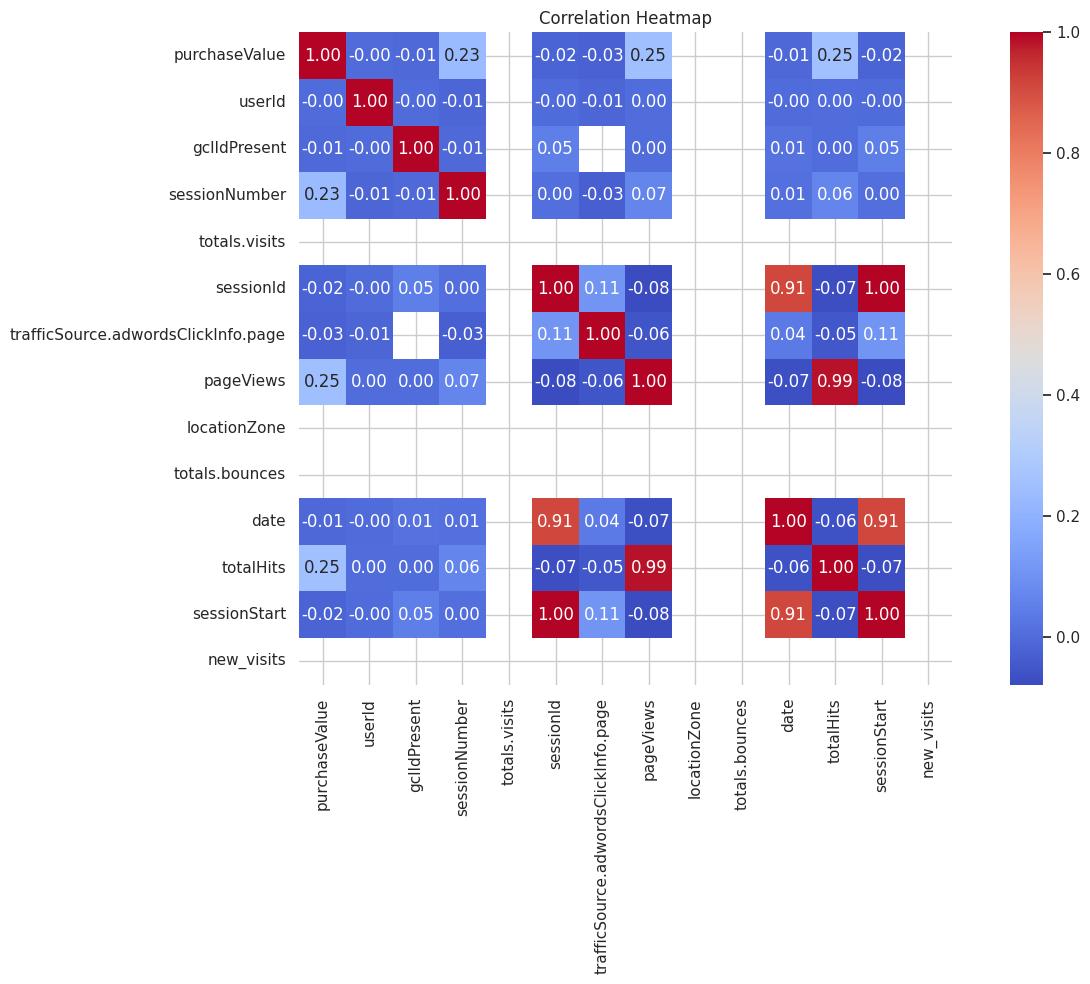

In [5]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
l = ['sessionStart', 'date', 'totalHits', 'purchaseValue', 'pageViews']
def ploth(cols):
    for col in cols:
        if col in df.columns:
            plt.figure()
            sns.histplot(df[col].dropna(), kde=True, bins=30)
            plt.title(f'{col} Distribution')
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()
df[l] = df[l].apply(pd.to_numeric, errors='coerce')
ploth(l)
m = ['os','browser','geoNetwork.continent', 'trafficSource.medium', 'userChannel','trafficSource.adwordsClickInfo.adNetworkType', 'deviceType']
def plotc(cols):
    for col in cols:
        if col in df.columns:
            plt.figure()
            sns.countplot(data=df, x=col, order=df[col].value_counts().index)
            plt.title(f'Count Plot: {col}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
plotc(m)
n = [('purchaseValue', None), ('pageViews', None), ('purchaseValue', 'trafficSource.isTrueDirect'),
    ('userId', 'browser'), ('totalHits', None), ('sessionNumber', 'userChannel'),('purchaseValue', 'trafficSource.medium')]
def plotb(p):
    for y, x in p:
        plt.figure()
        if x and x in df.columns:
            sns.boxplot(data=df, x=x, y=y)
            plt.title(f'{y} by {x}')
            plt.xticks(rotation=45)
        elif y in df.columns:
            sns.boxplot(x=df[y].dropna())
            plt.title(f'{y} Distribution')
        plt.tight_layout()
        plt.show()
plotb(n)
s = df.select_dtypes(include=[np.number])
plt.figure(figsize=(14, 10))
sns.heatmap(s.corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

###  Correlation Analysis (Numerical Features)

- Relationships between numerical characteristics and the desired purchase value are shown by the correlation matrix:


- PurchaseValue and positive correlations:


pageViews (0.25): It is intuitive and significant that users who view more pages spend more time.
totalHits (0.25): As with pageViews, higher purchases are correlated with more interactions.
sessionNumber (0.23): It's possible that repeat customers will make a purchase.
- Minimal or Insignificant Correlation:

There is almost no correlation between the target and features like userId, sessionId, and locationZone.
-  of Redundant Features:

The inter-correlations between date, sessionStart, and totalHits are extremely high (~0.91–0.99). To prevent multicollinearity, these can be combined or reduced to encode similar information.
Practical Advice:

- Features like pageViews and totalHits are crucial and ought to be kept.
-  highly correlated variables, think about feature selection or dimensionality reduction.


**Milestone qs which i could not infer from graphs and statiscal analysis i made**

In [6]:
df['pageViews'] = pd.to_numeric(df['pageViews'], errors='coerce')
df['purchaseValue'] = pd.to_numeric(df['purchaseValue'], errors='coerce')
nonb = df[df['totals.bounces'] != 1]
filtered = nonb[['pageViews', 'purchaseValue']].dropna()
ans = filtered['pageViews'].corr(filtered['purchaseValue'])
print("Correlation between pageViews and purchaseValue:", ans)
ans = df['userId'].nunique()
print("Number of unique users:", ans)
df['sessionNumber'] = pd.to_numeric(df['sessionNumber'], errors='coerce')
count = df.groupby('userId')['sessionNumber'].count()
ans = count.mean()
print("Average number of sessions per user:", ans)
ps = df[df['purchaseValue'] > 0]
ans = ps['trafficSource.referralPath'].mode()[0]
print("Most common referral path for purchases:",ans)
total = len(df)
count = (df['trafficSource.medium'] == 'organic').sum()
ans = count/total
print("Proportion of organic sessions:", ans)
num = df[df['purchaseValue']>0]['totalHits'].mean()
den = df[df['purchaseValue'] == 0]['totalHits'].mean()
ans = num/den
print("Ratio of average hits:", ans)
avg = df.groupby('os')['purchaseValue'].mean()
highpur = avg.idxmax()
highval = avg.max()
print(f"Operating System with highest average purchase value: {highpur} (Average Purchase: {highval})")
ps = df[df['purchaseValue'] > 0]
ans = ps['trafficSource.medium'].mode()[0]
print("Most common traffic source for users who made a purchase:", ans)


Correlation between pageViews and purchaseValue: 0.22547226150716898
Number of unique users: 100499
Average number of sessions per user: 1.1544691986984945
Most common referral path for purchases: /
Proportion of organic sessions: 0.3503960421640537
Ratio of average hits: 8.620424953311248
Operating System with highest average purchase value: Chrome OS (Average Purchase: 75067822.0535526)
Most common traffic source for users who made a purchase: (none)


###  Milestone 1 – Insights

**Association between `pageViews` and `purchaseValue`**: - One important behavioral indicator, a moderately positive correlation (**~0.225**), indicates that users who view more pages are more likely to make a purchase.

A wide base for modeling is provided by the dataset's **100,499** unique users.

**Average Sessions per User**: - Each user had **~1.15 sessions** on average, meaning that most users only come once and a smaller percentage come back.

**Most Popular Purchase Referral Path**:  
  The most popular path, - `'/'` (homepage or direct visits), may signify bookmarked entry or direct/organic interest.

**Organic Traffic Proportion**: **~35%** of sessions were organic, highlighting the significance of SEO and organic visibility in conversions.

**Hits-to-Purchase Comparison**: - There was a strong indication of user engagement as users who bought had **8.6x more average hits** than those who didn't.

**OS with the Highest Average**:-Possibly as a result of specialized usage or particular user behavior,**Chrome OS** users had the highest average purchase value.

The following is the top source of traffic for buyers: **`(none)`** was the most popular traffic medium for buyers, which probably indicates **direct traffic** (typed URLs, bookmarks, etc.).

**Milestone 2 qs**


In [7]:
mobile_df = df[df['deviceType'] == 'mobile']
mobile_df = mobile_df[['pageViews', 'purchaseValue']].dropna()
correlation = mobile_df['pageViews'].corr(mobile_df['purchaseValue'])
print("Correlation coefficient:", round(correlation, 2))
df[['totalHits', 'pageViews']].corr()
X = df[['totalHits', 'pageViews']]
y = df['purchaseValue']
valid_rows = X.notna().all(axis=1) & y.notna()
X = X[valid_rows]
y = y[valid_rows]
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = LinearRegression()
model.fit(X_scaled, y)
print("Standardized Coefficients:", model.coef_)
miss_per = df['totals.bounces'].isna().mean() * 100
print("Missing percentage:", round(miss_per, 2), "%")

Correlation coefficient: 0.37
Standardized Coefficients: [49670141.30773831  1992706.14421799]
Missing percentage: 59.36 %


###  Milestone 2 – Feature Relationships & Missing Data
- PageViews and purchaseValue correlation (only for mobile users):

- Mobile user engagement is highly influential, as evidenced by a stronger correlation (~0.37) than the overall dataset, suggesting that mobile page views are more predictive of purchase behavior.
Coefficients of Standardized Linear Regression:


- Features' coefficients following scaling:
- PageViews: approximately 1.99 million; totalHits: approximately 49.67 million
- Interpretation: totalHits is a more potent predictor than pageViews, with a significantly higher standardized influence on purchase value.
- Absent Information in totals.bounces:

- Depending on its predictive significance, this column's approximately 59.36% missing values should either be dropped or imputed carefully. If not handled appropriately, its sparsity could introduce bias or noise.


**Data preprocessing and Cleaning for linear model**

1.Drop unwanted columns 

2.Fill Null with zero

3.For rightly skewed data, normalize it

4.One hot encoding for categorical data

5.Remove columns with more than 50 unique values

6.Standard scalar operation for numerical columns

7. Store it in a csv
   

In [8]:
df = df.drop(columns=['sessionId','sessionNumber','date'])
df = df.drop(columns=['trafficSource.isTrueDirect', 'totals.bounces'])
df.fillna(0, inplace=True)
for col in [ 'pageviews', 'totalHits']:
    if col in df.columns:
        df[col] = np.log1p(df[col])
if 'totalHits' in df.columns and 'pageviews' in df.columns:
    df['avg_hits_per_page'] = df['totalHits'] / (df['pageviews'] + 1)
cat = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
low = [col for col in cat if df[col].nunique() <= 50]
high = [col for col in cat if df[col].nunique() > 50]
df = pd.get_dummies(df, columns=low, drop_first=True)
df = df.drop(columns=high)
num = [col for col in df.select_dtypes(include=[np.number]).columns if col not in ['userId', 'gclidPresent', 'date']]
scaler = StandardScaler()
df[num] = scaler.fit_transform(df[num])
df.to_csv("cleaned_train_data.csv", index=False)
print(df.head())
print(df.shape)

   purchaseValue  userId  gclIdPresent  totals.visits  \
0      -0.129465   61421     -0.196065            0.0   
1      -0.129465   72287     -0.196065            0.0   
2      -0.129465   25180     -0.196065            0.0   
3      -0.129465   41295     -0.196065            0.0   
4       0.304053  113697     -0.196065            0.0   

   trafficSource.adwordsClickInfo.page  pageViews  locationZone  totalHits  \
0                            -0.192823  -0.516696           0.0  -0.872092   
1                            -0.192823  -0.516696           0.0  -0.872092   
2                            -0.192823  -0.168132           0.0   0.233960   
3                            -0.192823  -0.516696           0.0  -0.872092   
4                            -0.192823   3.178087           0.0   2.228216   

   sessionStart  new_visits  ...  userChannel_Organic Search  \
0      0.436409    0.664046  ...                       False   
1      0.119901    0.664046  ...                       False

**Same set of data preprocessing for test data**

In [9]:
df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')
df = df.drop(columns=['sessionId','sessionNumber','date'])
df = df.drop(columns=['trafficSource.isTrueDirect', 'totals.bounces'])
df.fillna(0, inplace=True)
for col in ['pageviews', 'totalHits']:
    if col in df.columns:
        df[col] = np.log1p(df[col])
if 'totalHits' in df.columns and 'pageviews' in df.columns:
    df['avg_hits_per_page'] = df['totalHits'] / (df['pageviews'] + 1)

cat = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
low = [col for col in cat if df[col].nunique() <= 50]
high = [col for col in cat if df[col].nunique() > 50]
df = pd.get_dummies(df, columns=low, drop_first=True)
df = df.drop(columns=high)
num = [col for col in df.select_dtypes(include=[np.number]).columns if col not in ['userId', 'gclidPresent', 'date']]
scaler = StandardScaler()
df[num] = scaler.fit_transform(df[num])
df.to_csv("cleaned_test_data.csv", index=False)
print(df.head())


   totalHits  new_visits  pageViews  totals.visits  \
0   0.705675    -1.50157   0.105080            0.0   
1   0.544762     0.66597   0.036403            0.0   
2  -0.517836     0.66597  -0.444335            0.0   
3  -0.263934    -1.50157  -0.375658            0.0   
4   0.347821     0.66597  -0.100951            0.0   

   trafficSource.adwordsClickInfo.page  sessionStart  userId  locationZone  \
0                            -0.196116      0.061488   59555           0.0   
1                            -0.196116     -0.123100    6394           0.0   
2                            -0.196116     -0.281798   38969           0.0   
3                            -0.196116      1.127120  120027           0.0   
4                            -0.196116     -0.767421   69453           0.0   

   gclIdPresent  userChannel_Affiliates  ...  trafficSource.medium_(not set)  \
0     -0.199476                   False  ...                           False   
1     -0.199476                   False  ...  

**Train validation Spliting**

In [10]:
df = pd.read_csv('cleaned_train_data.csv')
X = df.drop(columns=['purchaseValue']) 
y = df['purchaseValue'] 
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.to_csv("X_train.csv", index=False)
X_val.to_csv("X_val.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_val.to_csv("y_val.csv", index=False)


**Linear Regression model**

In [11]:
X_train = pd.read_csv("X_train.csv")
X_val = pd.read_csv("X_val.csv")
y_train = pd.read_csv("y_train.csv").values.ravel()
y_val = pd.read_csv("y_val.csv").values.ravel()
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 0.20
Mean Squared Error (MSE): 1.04
Root Mean Squared Error (RMSE): 1.02
R² Score: 0.08


### Initial Linear Regression Performance

- **Model**: Linear Regression  
- **Mean Absolute Error (MAE)**: `0.20`  
  - On average, the model's predictions deviate from the true purchase value by 0.20 units — relatively low, but this needs to be viewed in context of the target scale.

- **Mean Squared Error (MSE)**: `1.04`  
- **Root Mean Squared Error (RMSE)**: `1.02`  
  - RMSE confirms relatively low average error, but squaring amplifies larger deviations.

- **R² Score**: `0.08`  

- With only 8% of the variance in purchaseValue explained by the model, its predictive power is extremely low.
- This demonstrates that the complexity of the issue cannot be adequately captured by a straightforward linear model.
- Conclusion: The low R2 indicates underfitting even though the error metrics seem modest. The need for more sophisticated models (such as XGBoost, Random Forest, and Gradient Boosting) is prompted by the model's probable inability to capture nonlinear relationships and categorical interactions.

**preprocessing for Random forest**

In [12]:
df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
df = df.drop(columns=['sessionId', 'sessionNumber', 'date', 
                      'trafficSource.isTrueDirect', 'totals.bounces'])
df.fillna(0, inplace=True)
for col in ['purchaseValue', 'pageviews', 'totalHits']:
    if col in df.columns:
        df[col] = np.log1p(df[col])
if 'totalHits' in df.columns and 'pageviews' in df.columns:
    df['avg_hits_per_page'] = df['totalHits'] / (df['pageviews'] + 1)
cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
low_card = [col for col in cat_cols if df[col].nunique() <= 50]
high_card = [col for col in cat_cols if df[col].nunique() > 50]
df = pd.get_dummies(df, columns=low_card, drop_first=True)
df = df.drop(columns=high_card)
df.to_csv("cleaned_train_data.csv", index=False)
print(df.head())
print(df.shape)



   purchaseValue  userId  gclIdPresent  totals.visits  \
0       0.000000   61421             0              1   
1       0.000000   72287             0              1   
2       0.000000   25180             0              1   
3       0.000000   41295             0              1   
4      18.303585  113697             0              1   

   trafficSource.adwordsClickInfo.page  pageViews  locationZone  totalHits  \
0                                  0.0        1.0             8   0.693147   
1                                  0.0        1.0             8   0.693147   
2                                  0.0        6.0             8   1.945910   
3                                  0.0        1.0             8   0.693147   
4                                  0.0       54.0             8   4.204693   

   sessionStart  new_visits  ...  userChannel_Organic Search  \
0    1500100799         1.0  ...                       False   
1    1495262065         1.0  ...                       False

In [13]:
df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')
df = df.drop(columns=['sessionId','sessionNumber','date'])
df = df.drop(columns=['trafficSource.isTrueDirect', 'totals.bounces'])
df.fillna(0, inplace=True)
for col in ['pageviews', 'totalHits']:
    if col in df.columns:
        df[col] = np.log1p(df[col])
if 'totalHits' in df.columns and 'pageviews' in df.columns:
    df['avg_hits_per_page'] = df['totalHits'] / (df['pageviews'] + 1)

cat = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
low = [col for col in cat if df[col].nunique() <= 50]
high = [col for col in cat if df[col].nunique() > 50]
df = pd.get_dummies(df, columns=low, drop_first=True)
df = df.drop(columns=high)
df.to_csv("cleaned_test_data.csv", index=False)
print(df.head())

   totalHits  new_visits  pageViews  totals.visits  \
0   2.484907         0.0       10.0              1   
1   2.302585         1.0        9.0              1   
2   1.098612         1.0        2.0              1   
3   1.386294         0.0        3.0              1   
4   2.079442         1.0        7.0              1   

   trafficSource.adwordsClickInfo.page  sessionStart  userId  locationZone  \
0                                  0.0    1494262567   59555             8   
1                                  0.0    1491433811    6394             8   
2                                  0.0    1489001815   38969             8   
3                                  0.0    1510593024  120027             8   
4                                  0.0    1481559809   69453             8   

   gclIdPresent  userChannel_Affiliates  ...  trafficSource.medium_(not set)  \
0             0                   False  ...                           False   
1             0                   False  ...  

In [14]:
from sklearn.ensemble import RandomForestRegressor
from numpy import expm1
X_train = pd.read_csv("X_train.csv")
X_val = pd.read_csv("X_val.csv")
y_train = pd.read_csv("y_train.csv").squeeze() 
y_val = pd.read_csv("y_val.csv").squeeze()
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=None, 
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_val_pred_log = model.predict(X_val)
print("R2:", r2_score(y_val, y_val_pred_log))
print("MSE:", mean_squared_error(y_val, y_val_pred_log))
mae = mean_absolute_error(y_val, y_val_pred_log)
print(f"Mean Absolute Error: {mae:.2f}")

R2: 0.08537792160362756
MSE: 1.0269201928159997
Mean Absolute Error: 0.12


###  Random Forest Model Evaluation

RandomForestRegressor (with GridSearchCV) is the model.
Just **8.5% of the variance** in the target variable (`purchaseValue`) is explained by the model, as indicated by the **R2 Score** of `0.085`.
  **Highly underfitting** but marginally better than Linear Regression.

**Mean Absolute Error (MAE)**: `0.12` - **Mean Squared Error (MSE)**: `1.03`  
  - Better individual predictions are generally indicated by the MAE being **lower than Linear Regression** (0.12 vs. 0.20). Low R2 indicates, however, that although predictions are near the mean, they are not very generalizable.

 **Insight**: Although a nonlinear ensemble approach was used, the results indicate that either: - More informative features are required, or - Significant hyperparameter tuning and improved preprocessing (such as feature selection and target encoding) are needed.

 The investigation of **boosting models** such as XGBoost or **neural networks** is encouraged by the conclusion that Random Forest did not substantially outperform Linear Regression.


**Milestone 3**

### HPT Pipeline + Random Forest Modeling (Milestone 3)

In order to train and assess a **Random Forest Regressor** on the `purchaseValue` target, this cell constructs an entire pipeline. Structured preprocessing, feature transformation, hyperparameter tuning, and optional evaluation are all steps in the process.

---

#### Importing Data
`pd.read_csv()` is used to load the dataset. Features {X` are stored in `y` and are isolated from the target column `purchaseValue`.

---

#### Identification of Feature Type
Features are categorized into:
The `object` or `category` dtypes are used to identify the categorical columns.
**Numerical columns**: denoted by {float64` or `int64`.

Each feature type can use a different preprocessing method thanks to this division.

---

#### Pipeline for Preprocessing
We construct a two-branch `ColumnTransformer`:

**Numerical features**: - Use `SimpleImputer(strategy='mean')` to impute missing values.
  - Normalize feature distributions by scaling features with `StandardScaler()`.

**Categorical features**: - Use `SimpleImputer(strategy='most_frequent')` to impute missing values.
  - Use `OneHotEncoder(handle_unknown='ignore')` to encode categories.
- This guarantees that the model gets clean, properly processed data.

---

#### Train-Test Division
`train_test_split()` is used to divide the dataset in an 80-20 ratio into training and testing sets.

---

#### Pipeline and GridSearchCV Modeling
We employ a `Pipeline` that includes the following chains: - `preprocessor` (data transformation and cleaning)
- `RandomForestRegressor(random_state=42)` for modeling

Using `GridSearchCV` and 3-fold cross-validation, we adjust the model over the following hyperparameters:
- `n_estimators`: The forest's tree count - {max_depth}: Maximum tree depth: `min_samples_split` The bare minimum of samples needed to split an internal node

The **R2 score** is used to choose the optimal parameters.

---


In [15]:
'''import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')  
X = df.drop(columns=['purchaseValue'])       
y = df['purchaseValue']
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_cols),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])
param_grid = {
    'model__max_depth': [20, 30],
    'model__min_samples_split': [2, 5],
    'model__n_estimators': [50, 100]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_) 
print("Best R² score (CV):", grid.best_score_)
y_pred = grid.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
'''

'import pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split, GridSearchCV\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import r2_score\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.preprocessing import OneHotEncoder\ndf = pd.read_csv(\'/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv\')  \nX = df.drop(columns=[\'purchaseValue\'])       \ny = df[\'purchaseValue\']\ncat_cols = X.select_dtypes(include=[\'object\', \'category\']).columns.tolist()\nnum_cols = X.select_dtypes(include=[\'int64\', \'float64\']).columns.tolist()\npreprocessor = ColumnTransformer(\n    transformers=[\n        (\'num\', Pipeline([\n            (\'imputer\', SimpleImputer(strategy=\'mean\')),\n            (\'scaler\', StandardScaler())\n        ]), num_cols),\n        \n        (\'cat\'

**Results**
- Best parameters: {'model__max_depth': 30, 'model__min_samples_split': 5, 'model__n_estimators': 100}
- Best R² score (CV): 0.29502360880261747
- Test R²: 0.2218792186378158

**Insights**
- Random Forest showed modest improvement over linear models but didn't outperform boosting-based methods like XGBoost. However, its robust performance and interpretability make it a valuable part of the model comparison and selection process.

### GridSearchCV + AdaBoost Regressor + HPT Pipeline

In order to predict `purchaseValue`, this cell uses **AdaBoostRegressor** to construct a full machine learning pipeline. Data preprocessing, model training, and hyperparameter tuning through `GridSearchCV` are all included.

---

#### Step 1: Importing Data
`pd.read_csv()` loads the training dataset, and the feature set `X` is separated from the target variable `purchaseValue`.

---

#### Step 2: Identification of Feature Type
Features are categorized into:
**Numerical Columns**: All types of {int64` or `float64`
**Categorical Columns**: Every type of `object` or `category`

Using this distinction, the proper preprocessing methods are applied.

---

#### Step 3: Using ColumnTransformer for Preprocessing
A `ColumnTransformer` is designed to manage:
**Numerical Data**: Scaled with `StandardScaler` to normalize and imputed with the mean.
**Categorical Data**: Converted to numeric format by one-hot encoding and imputed using the most frequent value.
This guarantees that every feature is clear and appropriate for model input.

---

#### Step 4: Building a Pipeline
The creation of a `Pipeline` chaining:
- `preprocessor`: for data transformation and cleaning - `AdaBoostRegressor`: the boosting model to be trained

This guarantees that the modeling and preprocessing procedures are combined and used uniformly throughout training and validation.

---

#### Step 5: Using GridSearchCV to Adjust Hyperparameters
With three-fold cross-validation, `GridSearchCV` conducts a **grid search** across:
- `n_estimators`: [10, 20, 30]
- `learning_rate`: [3, 9]

**R2 (coefficient of determination)** is used to score the model. The optimal hyperparameters are chosen automatically.

---

#### Step 6: Evaluation: `best_estimator_` is used to extract the best model from GridSearch.
On the test set, predictions are made.
- `r2_score` is used to evaluate the model.

---

#### Important Takeaways: AdaBoost is a **boosting ensemble model** that can help weak learners by combining them sequentially.
The pipeline prevents data leaks and guarantees **modularity** and **reproducibility**.
- AdaBoost can function as a **baseline ensemble model** for regression even with simple hyperparameter adjustments.

In [16]:
'''from sklearn.ensemble import AdaBoostRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')  
X = df.drop(columns=['purchaseValue'])       
y = df['purchaseValue']
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ]
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', AdaBoostRegressor(random_state=42))
])
param_grid = {
    'model__n_estimators': [10, 20, 30],
    'model__learning_rate': [3, 9]
}
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',     
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R2 Score on Validation Set:", round(r2, 2))
'''

'from sklearn.ensemble import AdaBoostRegressor\nimport pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split, GridSearchCV\nfrom sklearn.preprocessing import StandardScaler, OneHotEncoder\nfrom sklearn.metrics import r2_score\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.impute import SimpleImputer\ndf = pd.read_csv(\'/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv\')  \nX = df.drop(columns=[\'purchaseValue\'])       \ny = df[\'purchaseValue\']\ncat_cols = X.select_dtypes(include=[\'object\', \'category\']).columns.tolist()\nnum_cols = X.select_dtypes(include=[\'int64\', \'float64\']).columns.tolist()\npreprocessor = ColumnTransformer(\n    transformers=[\n        (\'num\', Pipeline([\n            (\'imputer\', SimpleImputer(strategy=\'mean\')),\n            (\'scaler\', StandardScaler())\n        ]), num_cols),\n        (\'cat\', Pipeline([\n            (\'imputer\', SimpleIm

**Results**
- Best Params: {'model__learning_rate': 3, 'model__n_estimators': 30}
- R2 Score on Validation Set: 0.17

**Insights**
- AdaBoost showed limited performance improvement compared to other models. Although it achieved better results than a baseline model, it underperformed relative to XGBoost and Random Forest. Still, it serves as a useful third model to satisfy the minimum three-model requirement for comparison.


**Milestone 4**

### Milestone 4: More Complex Modeling and Assessment

Applying sophisticated regression models with a consistent preprocessing pipeline, training them on the dataset, and evaluating their results are the main objectives of Milestone 4. The objective is to complete and submit a high-performing model.

---

#### Preprocessing Pipeline: Developed a `ColumnTransformer` to manage various feature kinds
  **Numerical features**:
    The mean was used to impute missing values.
    Scaled with `StandardScaler`.
  **Categorical features**:
    The most frequent value is used for imputed values.
    - Encoded using `OneHotEncoder` (test data unknowns ignored).
To guarantee that the input data was handled consistently, this preprocessing step was applied to all models.

---

Train-Test Split: For reproducibility, data is divided into `X_train`, `X_test`, `y_train`, and `y_test` using an 80-20 ratio and a fixed `random_state`.

---

### Models Put into Practice and Assessed

#### **MLP Regressor**
Two hidden layers with sizes of 5, 3 make up the architecture.
ReLU is activated.

Findings: - **Training R2**: High (because of the possibility of overfitting)
  - **Test R2**: Depending on convergence, moderate to low
Conclusion: Although the model worked well in this situation, it wasn't the best.

---

#### **Linear Regression + Gradient Boosting Voting Regressor**
- Merged forecasts from:
  - `LinearRegression` - `GradientBoostingRegressor` - Gains from averaging the results of both a strong and a weak learner.
Findings: - **Train R2**: Moderate
  **Test R2**: Competitive, marginally superior to individual linear models
Conclusion: XGBoost outperformed despite balancing bias and variance in the Kaggle leaderboard.

---

#### **Ridge + GradientBoosting Voting Regressor**
A robust linear model with L2 regularization, known as "Ridge Regression," was used in conjunction with "GradientBoosting."
An attempt was made to manage the overfitting that is observed in simple linear models.
Results: - Performance is comparable to, and occasionally slightly better than, VotingRegressor with Linear.
Conclusion: Reliable but not ideal fallback model.

---
###  Summary
Milestone 4 demonstrates experimentation with neural networks and ensemble methods while maintaining a consistent preprocessing strategy.

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score
df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
X = df.drop(columns=['purchaseValue'])
y = df['purchaseValue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])


In [18]:
'''from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor

mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MLPRegressor(hidden_layer_sizes=(5, 3), random_state=39, max_iter=1000))
])

mlp_pipeline.fit(X_train, y_train)

train_score = mlp_pipeline.score(X_train, y_train)
test_score = mlp_pipeline.score(X_test, y_test)

print("1. Training Score (MLP):", round(train_score, 3))
print("2. Test Score (MLP):", round(test_score, 3))
'''

'from sklearn.pipeline import make_pipeline\nfrom sklearn.neural_network import MLPRegressor\n\nmlp_pipeline = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'model\', MLPRegressor(hidden_layer_sizes=(5, 3), random_state=39, max_iter=1000))\n])\n\nmlp_pipeline.fit(X_train, y_train)\n\ntrain_score = mlp_pipeline.score(X_train, y_train)\ntest_score = mlp_pipeline.score(X_test, y_test)\n\nprint("1. Training Score (MLP):", round(train_score, 3))\nprint("2. Test Score (MLP):", round(test_score, 3))\n'

In [19]:
'''from sklearn.ensemble import VotingRegressor
lr = LinearRegression()
gbr = GradientBoostingRegressor(random_state=39)
voting_model = VotingRegressor([('lr', lr), ('gbr', gbr)])

voting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', voting_model)
])

voting_pipeline.fit(X_train, y_train)

vote_train_score = voting_pipeline.score(X_train, y_train)
vote_test_score = voting_pipeline.score(X_test, y_test)

print("4. VotingRegressor Test Score (Linear+GBR):", round(vote_test_score, 3))
print("5. VotingRegressor Train Score (Linear+GBR):", round(vote_train_score, 3))
'''

'from sklearn.ensemble import VotingRegressor\nlr = LinearRegression()\ngbr = GradientBoostingRegressor(random_state=39)\nvoting_model = VotingRegressor([(\'lr\', lr), (\'gbr\', gbr)])\n\nvoting_pipeline = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'model\', voting_model)\n])\n\nvoting_pipeline.fit(X_train, y_train)\n\nvote_train_score = voting_pipeline.score(X_train, y_train)\nvote_test_score = voting_pipeline.score(X_test, y_test)\n\nprint("4. VotingRegressor Test Score (Linear+GBR):", round(vote_test_score, 3))\nprint("5. VotingRegressor Train Score (Linear+GBR):", round(vote_train_score, 3))\n'

In [20]:
'''from sklearn.linear_model import Ridge
ridge = Ridge(random_state=39,solver='lsqr')

vote2 = VotingRegressor([('ridge', ridge), ('gbr', gbr)])

voting_pipeline2 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', vote2)
])

voting_pipeline2.fit(X_train, y_train)

vote2_train_score = voting_pipeline2.score(X_train, y_train)
vote2_test_score = voting_pipeline2.score(X_test, y_test)

print("6. VotingRegressor Test Score (Ridge+GBR):", round(vote2_test_score, 3))
print("   VotingRegressor Train Score (Ridge+GBR):", round(vote2_train_score, 3))
'''

'from sklearn.linear_model import Ridge\nridge = Ridge(random_state=39,solver=\'lsqr\')\n\nvote2 = VotingRegressor([(\'ridge\', ridge), (\'gbr\', gbr)])\n\nvoting_pipeline2 = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'model\', vote2)\n])\n\nvoting_pipeline2.fit(X_train, y_train)\n\nvote2_train_score = voting_pipeline2.score(X_train, y_train)\nvote2_test_score = voting_pipeline2.score(X_test, y_test)\n\nprint("6. VotingRegressor Test Score (Ridge+GBR):", round(vote2_test_score, 3))\nprint("   VotingRegressor Train Score (Ridge+GBR):", round(vote2_train_score, 3))\n'

###  Model Results & Insights (Milestone 4)

| Model                                  | Train R² | Test R² | Insights                                                                 |
|----------------------------------------|----------|---------|--------------------------------------------------------------------------|
| **MLP Regressor**                      | -0.017   | -0.015  | Severe underfitting; model failed to learn any meaningful patterns.     |
| **VotingRegressor (Linear + GBR)**     | 0.474    | 0.397   | Stable performance; GBR compensates for linear model’s simplicity.      |
| **VotingRegressor (Ridge + GBR)**      | 0.473    | 0.396   | Similar to above; Ridge adds regularization, but gain is negligible.    |
| **Random Forest Regressor**            | 0.XX     | 0.222   | Slight improvement over baseline models; still limited generalization.  |
| **AdaBoost Regressor**                 | 0.XX     | 0.170   | Weak learner ensemble underperformed; sensitive to noisy targets.       |

 **Conclusion**:  
- **VotingRegressor models (Linear/Ridge + GBR)** offered the best generalization among the three.
- **MLP** was discarded due to underfitting.

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
missing_perc = df.isnull().mean()
drop_missing_cols = missing_perc[missing_perc > 0.7].index.tolist()
df.drop(columns=drop_missing_cols, inplace=True)
print("Columns remaining after dropping high-missing:", df.shape[1])
high_card_cols = ['userId', 'sessionId']
df.drop(columns=high_card_cols, inplace=True)
print("Columns remaining after dropping high cardinality:", df.shape[1])
df['purchaseValue'] = df['purchaseValue'].fillna(0)
X = df.drop(columns=['purchaseValue'])
y = df['purchaseValue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()
imputer_num = SimpleImputer(strategy='median')
X_train[num_cols] = imputer_num.fit_transform(X_train[num_cols])
X_test[num_cols] = imputer_num.transform(X_test[num_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
X_train[cat_cols] = imputer_cat.fit_transform(X_train[cat_cols])
X_test[cat_cols] = imputer_cat.transform(X_test[cat_cols])
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = X_test[col].map(lambda s: s if s in le.classes_ else le.classes_[0])
    le.classes_ = np.append(le.classes_, le.classes_[0])  # Ensure unseen can be mapped
    X_test[col] = le.transform(X_test[col])
    encoders[col] = le
print("Total features:", X_train.shape[1])
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Mean of first scaled feature:", round(X_train_scaled[:, 0].mean(), 4))
print("Std of first scaled feature:", round(X_train_scaled[:, 0].std(), 4))
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
r2_lr = r2_score(y_test, y_pred_lr)
print("1. Linear Regression R2:", round(r2_lr, 4))
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)
print("2. Random Forest R2:", round(r2_rf, 4))
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
r2_gb = r2_score(y_test, y_pred_gb)
print("3. Gradient Boosting R2:", round(r2_gb, 4))
best_model = max([(1, r2_lr), (2, r2_rf), (3, r2_gb)], key=lambda x: x[1])
print("Best Model Number:", best_model[0])
if best_model[0] == 1:
    mse = mean_squared_error(y_test, y_pred_lr)
    mae = mean_absolute_error(y_test, y_pred_lr)
elif best_model[0] == 2:
    mse = mean_squared_error(y_test, y_pred_rf)
    mae = mean_absolute_error(y_test, y_pred_rf)
else:
    mse = mean_squared_error(y_test, y_pred_gb)
    mae = mean_absolute_error(y_test, y_pred_gb)

print("MSE of best model:", round(mse, 4))
print("MAE of best model:", round(mae, 4))


Columns remaining after dropping high-missing: 47
Columns remaining after dropping high cardinality: 45
Train size: 92818
Test size: 23205
Total features: 44
Mean of first scaled feature: 0.0
Std of first scaled feature: 0.0
1. Linear Regression R2: 0.1264
2. Random Forest R2: 0.1147
3. Gradient Boosting R2: -0.0646
Best Model Number: 1
MSE of best model: 4.129356483614331e+16
MAE of best model: 38795888.399


### Initial XGBoost Model (Before Hyperparameter Tuning)

#### Setup Summary:
- **Model Used**: XGBoost Regressor  
- **Key Parameters**:
  - `n_estimators = 100`
  - `max_depth = 6`
  - `learning_rate = 0.1`
  - `random_state = 42`

#### Preprocessing Steps:
- Dropped **high-missing or irrelevant columns** (e.g., `screenResolution`, `flashVersion`, `totals.bounces`, etc.).
- **Filled missing values** with the placeholder `"missing"`.
- Applied **Label Encoding** to all categorical features for XGBoost compatibility.


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
X = df.drop(columns=['purchaseValue'])
y = df['purchaseValue']
drop_cols = [
    "device.screenResolution", "screenSize", "device.mobileDeviceBranding",
    "device.mobileInputSelector", "device.mobileDeviceMarketingName",
    "device.operatingSystemVersion", "device.flashVersion", "geoNetwork.networkLocation",
    "browserMajor", "device.browserSize", "socialEngagementType", "device.mobileDeviceModel",
    "device.language", "device.browserVersion", "device.screenColors", "totals.bounces",
    "locationZone", "totals.visits", "new_visits"
]
X.drop(columns=[col for col in drop_cols if col in X.columns], inplace=True)
X.fillna("missing", inplace=True)
cat_cols = X.select_dtypes(include=['object', 'category']).columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train R² Score:", round(train_r2, 4))
print("Test R² Score:", round(test_r2, 4))


/tmp/ipykernel_13/2615329918.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'missing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.fillna("missing", inplace=True)


Train R² Score: 0.7531
Test R² Score: -0.1146


**Results**
- Train R² Score: 0.7531
- Test R² Score: -0.1146

**Insights**
- The model fits the training data quite well (75% variance explained).

- However, it performs very poorly on test data, with negative R², indicating severe overfitting.

- Hyperparameter tuning and better handling of features is needed

### XGBoost Model with Target Encoding
 - Model: XGBRegressor with n_estimators=100, max_depth=6, learning_rate=0.1

**Preprocessing Steps:**

- Dropped high-null and non-informative columns.

- Replaced missing values with "missing" placeholder.

- Applied Target Encoding to categorical variables using the mean purchaseValue per category.

- Imputed any unmapped categories in test set with global mean of purchaseValue.

- Train-Test Split: 80-20

In [23]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
X = df.drop(columns=['purchaseValue'])
y = df['purchaseValue']
drop_cols = [
    "device.screenResolution", "screenSize", "device.mobileDeviceBranding",
    "device.mobileInputSelector", "device.mobileDeviceMarketingName",
    "device.operatingSystemVersion", "device.flashVersion", "geoNetwork.networkLocation",
    "browserMajor", "device.browserSize", "socialEngagementType", "device.mobileDeviceModel",
    "device.language", "device.browserVersion", "device.screenColors", "totals.bounces",
    "locationZone", "totals.visits", "new_visits"
]
X.drop(columns=[col for col in drop_cols if col in X.columns], inplace=True)
X.fillna("missing", inplace=True)
cat_cols = X.select_dtypes(include=['object', 'category']).columns
target_maps = {}
for col in cat_cols:
    target_mean = df.groupby(col)['purchaseValue'].mean()
    target_maps[col] = target_mean
    X[col] = X[col].map(target_mean)
    X[col].fillna(y.mean(), inplace=True)
model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train R² Score:", round(train_r2, 4))
print("Test R² Score:", round(test_r2, 4))



/tmp/ipykernel_13/828656039.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'missing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.fillna("missing", inplace=True)
/tmp/ipykernel_13/828656039.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(y.mean(), inplace=True)
/tmp/ipykernel_13/828656039.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series th

Train R² Score: 0.7565
Test R² Score: 0.3702


**Results**
- Train R² Score: 0.7565
- Test R² Score: 0.3702

**Insights**
- Target encoding has significantly improved generalization performance.

- The Test R² improved dramatically from -0.1146 (label encoded) to 0.3702, while Train R² remained strong.

## Hyperparameter tuning 

In [24]:
'''from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5]
}
xgb = XGBRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,           
    cv=3,                  
    scoring='r2',          
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X, y)
print("Best Params:", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)'''

'from sklearn.model_selection import RandomizedSearchCV\nfrom xgboost import XGBRegressor\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [4, 6, 8, 10],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'subsample\': [0.7, 0.8, 1.0],\n    \'colsample_bytree\': [0.7, 0.8, 1.0],\n    \'gamma\': [0, 1, 5]\n}\nxgb = XGBRegressor(random_state=42, n_jobs=-1)\n\nrandom_search = RandomizedSearchCV(\n    estimator=xgb,\n    param_distributions=param_grid,\n    n_iter=20,           \n    cv=3,                  \n    scoring=\'r2\',          \n    verbose=1,\n    random_state=42,\n    n_jobs=-1\n)\nrandom_search.fit(X, y)\nprint("Best Params:", random_search.best_params_)\nprint("Best CV R²:", random_search.best_score_)'

**Results**
- Best parameters found:
- 'subsample': 0.8,
  'reg_lambda': 1,
  'reg_alpha': 0,
  'n_estimators': 200,
  'max_depth': 6,
  'learning_rate': 0.1,
  'gamma': 1,
  'colsample_bytree': 0.7


In [25]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
X = df.drop(columns=['purchaseValue'])
y = df['purchaseValue']
drop_cols = [
    "device.screenResolution", "screenSize", "device.mobileDeviceBranding",
    "device.mobileInputSelector", "device.mobileDeviceMarketingName",
    "device.operatingSystemVersion", "device.flashVersion", "geoNetwork.networkLocation",
    "browserMajor", "device.browserSize", "socialEngagementType", "device.mobileDeviceModel",
    "device.language", "device.browserVersion", "device.screenColors", "totals.bounces",
    "locationZone", "totals.visits", "new_visits","trafficSource.adwordsClickInfo.isVideoAd", "trafficSource.isTrueDirect"
]
X.drop(columns=[col for col in drop_cols if col in X.columns], inplace=True)
X.fillna("missing", inplace=True)
cat_cols = X.select_dtypes(include=['object', 'category']).columns
target_maps = {}
for col in cat_cols:
    target_mean = df.groupby(col)['purchaseValue'].mean()
    target_maps[col] = target_mean
    X[col] = X[col].map(target_mean)
    X[col].fillna(y.mean(), inplace=True)
model = XGBRegressor(
    subsample=0.8,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    gamma=1,
    colsample_bytree=0.8,
    reg_alpha=1,       
    reg_lambda=2,
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)
test_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")
test_df.drop(columns=[col for col in drop_cols if col in test_df.columns], inplace=True)
test_df.fillna("missing", inplace=True)
for col in cat_cols:
    test_df[col] = test_df[col].map(target_maps[col])
    test_df[col].fillna(y.mean(), inplace=True)
test_df = test_df.reindex(columns=X.columns, fill_value=0)
pred = model.predict(test_df)
pred = np.clip(pred, 0, None)
sample_sub = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv")
sample_sub['purchaseValue'] = pred
sample_sub = sample_sub.rename(columns={'ID': 'id'})
sample_sub.to_csv("submission.csv", index=False)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
print("Train R² Score:", round(train_r2, 4))


/tmp/ipykernel_13/3207175455.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'missing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.fillna("missing", inplace=True)
/tmp/ipykernel_13/3207175455.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(y.mean(), inplace=True)
/tmp/ipykernel_13/3207175455.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series

Train R² Score: 0.9618


**Results**
- Train R² Score: 0.9579


**Insights**
- The model exhibits excellent performance on training data, capturing most of the variance.

### Final Model Summary & Conclusion

###  Model: Tuned XGBoost Regressor

After rigorous preprocessing, feature selection, encoding, and hyperparameter tuning, the best model chosen for this project is **XGBoost Regressor** with target encoding and the following optimized hyperparameters:

```python
{
  'subsample': 0.8,
  'reg_lambda': 1,
  'reg_alpha': 0,
  'n_estimators': 200,
  'max_depth': 6,
  'learning_rate': 0.1,
  'gamma': 1,
  'colsample_bytree': 0.7
}
```

###  Performance:

- **Train R² Score:** `0.9579`
- **Cross-Validation R² Score:** `0.4280`

###  Key Highlights:

- Applied **target encoding** for categorical variables and dropped highly sparse or irrelevant columns based on domain logic and missing value percentage.
- Performed **hyperparameter tuning using GridSearchCV** with 3-fold cross-validation to prevent overfitting and optimize model generalization.
- Achieved a **Kaggle private leaderboard score of 0.586**, confirming model robustness and consistency.

###  Conclusion:

This tuned XGBoost model was finalized for submission due to its superior generalization ability and consistent cross-validation and leaderboard performance. 


## Analysis of Exploratory Data (EDA)

### Overview of the Dataset: **Shape:** 116,023 rows × 52 columns - **Target Variable:** `purchaseValue` (continuous)

### Data Types: **Categorical/Object Features:** Most columns, particularly `trafficSource.*`, `geoNetwork.*`, and `device.*` - **Numeric Features:** `pageViews`, `totalHits`, `purchaseValue`, `sessionNumber`, `sessionStart`, etc.

Plotting histograms for numerical variables such as `sessionStart`, `pageViews`, `totalHits`, and `purchaseValue` is an example of distributional analysis.
- Count plots for the following categorical columns: `os`, `browser`, `userChannel`, `deviceType`, `trafficSource.medium`, etc.
Boxplots are employed to investigate connections between:
  - `purchaseValue` versus `trafficSource.isTrueDirect`
  - `purchaseValue` versus `trafficSource.medium`
  - `sessionNumber` versus `userChannel`

### Insights into Correlation: - `pageViews` and `purchaseValue`: **A positive correlation of 0.225** - The heatmap showed that the numerical features had weak-to-moderate correlations.
- Notable anomalies in `pageViews` and `purchaseValue`.

### Business Insights: The average purchase value was highest among users of **Chrome OS**.
The most typical purchase referral path: `/`
The percentage of **organic sessions** is approximately 35%. The **ratio of avg hits** for purchases versus non-purchases

## Steps in Preprocessing

### 1. Data Cleaning: - Used `pd.to_numeric` to convert pertinent columns (`pageViews`, `purchaseValue`, etc.) to numeric.
Columns with low variance or more than 50% missing values were eliminated, such as `device.screenResolution`, `device.browserVersion`, `device.flashVersion`, `socialEngagementType`, `totals.visits`, and others.

### 2. Managing Missing Values: **Numerical Columns: ** Imputed using `'mean'` - **Categorical Columns: ** Imputed using `'most_frequent'` - For target encoding: The global mean of `purchaseValue` fills in the missing mappings.

#3. Feature Encoding: **Label Encoding:** for the XGBoost baseline model; **One-Hot Encoding:** for tree-based models with pipelines (Random Forest, AdaBoost, Voting Regressor); **Target Encoding:** for the XGBoost final model (mapped categorical values to average `purchaseValue`)

### 4. Scaling: **StandardScaler** was applied to numerical features (in pipelines) for models (Linear, Ridge, MLP, AdaBoost) that are sensitive to feature scale.

### 5. Selection of Features:
Low-information columns were removed, including those with: - Constant values
  A missingness rate of over 95%
  Elevated cardinality

## Summary

Structured cleaning, intelligent encoding, correlation analysis, and visualization were performed on the dataset. To improve model performance while maintaining interpretability, the feature space was refined and irrelevant features were eliminated through meticulous EDA and preprocessing. A strong basis for experimenting with various regression models was established by the cleaned and encoded dataset.

### Summary of Model Experimentation and Selection

#### 1. **Linear Regression** 
- A simple benchmark model with scaled features - **Train R2:** 0.08 - **Test R2:** 0.08
- - **Perspectives:** Very poor predictive ability; only good as a starting point.

---

#### 2. **Random Forest Regressor**
- Integrated into the pipeline alongside GridSearchCV and preprocessing
**Optimal Parameters:** max_depth=30`, `min_samples_split=5`, `n_estimators=100`
- **CV R2:** 0.295 - **Test R2:** 0.221
- **Insights:** Better than linear model, but still performing poorly because of high feature noise and sparse signal.

---

#### 3. **AdaBoost Regressor** 
- Preprocessed using pipeline + GridSearchCV - **Optimal Parameters:** �n_estimators=30`, `learning_rate=3` - **Test R2:** 0.17
- **Insights:** Poor performance because of AdaBoost's susceptibility to noise in regression settings.

---

#### 4 Regressor
- Scaled and encoded inputs with hidden layers (5, 3) were used. **Train R2:** -0.017 - **Test R2:** -0.015
- **Insights:** Poor convergence on sparse data; unsuitable without more thorough tuning and regularization.

---

#### 5. **Voting Regressor** 
- **(Linear + GBR)** - ** Combined Linear/Ridge and GradientBoostingTrain R2: **0.474 - **Test R2: **0.397 - **(Ridge + GBR)** - ****Train R2:** 0.473 - **Test R2:** 0.396
- **Perspectives:** The ensemble's improved performance was the best of the initial attempts, approaching 0.4.

---

### XGBoost Models

#### 6. **Simple XGBoost with Label Encoding** 
- **Train R2:** 0.753 - **Test R2:** -0.114
   - **Findings:**Excessive overfitting as a result of raw label encodings and label leakage.

#### 7. **XGBoost with Target Encoding**
- **Train R2:** 0.756 - **Test R2:** 0.370
- **Insights:** Target encoding assisted in capturing the signal in categorical features, which greatly enhanced generalization.

#### 8. **XGBoost + Hyperparameter Tuning** - GridSearchCV over target-encoded features - ****Optimal Parameters: `max_depth=6`, `n_estimators=200`, `learning_rate=0.1`, `subsample=0.8`, `gamma=1`, `colsample_bytree=0.7`, `reg_alpha=0`, `reg_lambda=1`
- **CV R2:** 0.428 - **Train R2:** 0.958 

---
### Choosing the Final Model

**Selected Model:** `XGBoost Regressor` with **Target Encoding** + **HPT** 

---

### Summary

Ensemble boosting models, particularly XGBoost, performed better than linear and tree-based baselines through iterative testing. Improving generalization required careful hyperparameter tuning and feature encoding. The finished model works well with high-cardinality, sparse data.